<a href="https://colab.research.google.com/github/Davidenthoven/Fidel-Reconstruction-Demo/blob/main/FIdel_REconstruction_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import regularizers
from keras import optimizers

import numpy as np
import os
import tensorflow as tf
import sys
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
np.set_printoptions(threshold=sys.maxsize)
np.seterr(divide='ignore', invalid='ignore')

from random import randint
from IPython.display import clear_output

In [2]:
#set-up of Dataset
#dataset can be 'MNIST' or 'Cifar10'
dataset = 'Cifar10'
#model can be 'FCNN' or 'CNN'
modelname = 'CNN'

#MNIST
if (dataset == 'MNIST'):
  from keras.datasets import mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  input_shape = x_train.shape[1:]
  desired_shape = (28,28,1)
  n_classes = 10

#Cifar
elif (dataset == 'Cifar10'):
  from keras.datasets import cifar10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  input_shape = x_train.shape[1:]
  desired_shape = (32,32,3)
  n_classes = 10
  
#rescale to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# one-hot encoding of labels
y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test  = keras.utils.np_utils.to_categorical(y_test , n_classes)

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
#set-up the clients model

#activation function of first dense layer 'linear', 'relu', 'sigmoid', 'tanh'
a_function = 'relu' #activation function
use_dropout = False

#basic fcnn model
modelFCNN = keras.models.Sequential()                      
modelFCNN.add(keras.layers.Flatten(input_shape=input_shape))
modelFCNN.add(keras.layers.Dense(128, activation=a_function))
if(use_dropout):modelFCNN.add(keras.layers.Dropout(0.5))
modelFCNN.add(keras.layers.Dense(128, activation='relu')) 
modelFCNN.add(keras.layers.Dense(64, activation='relu')) 
modelFCNN.add(keras.layers.Dense(n_classes, activation='softmax'))
modelFCNN.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
#modelFCNN.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(), metrics=['accuracy'])

modelCNN = keras.models.Sequential()
modelCNN.add(keras.layers.Reshape(desired_shape, input_shape=input_shape))
modelCNN.add(keras.layers.Conv2D(32, kernel_size=(3,3))) 
modelCNN.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))                         
modelCNN.add(keras.layers.Flatten())                                              
modelCNN.add(keras.layers.Dense(128, activation=a_function))  
if(use_dropout):modelCNN.add(keras.layers.Dropout(0.5))
modelCNN.add(keras.layers.Dense(64, activation='relu'))
modelCNN.add(keras.layers.Dense(n_classes, activation='softmax'))
modelCNN.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

#get the right model
if (modelname == 'FCNN'):model = modelFCNN
elif (modelname == 'CNN'):model = modelCNN
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               921728    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [4]:
#train the "client" model with parameters
#!take note, model is not reset (unless rutime is restarted)
epochs = 30
batch_size = 128

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)
score = model.evaluate(x_test, y_test, batch_size=128)
print(score)

Epoch 1/30
391/391 [==============================] - 33s 10ms/step - loss: 2.0468 - accuracy: 0.2703 - val_loss: 1.9007 - val_accuracy: 0.3094
Epoch 2/30
391/391 [==============================] - 4s 9ms/step - loss: 1.8199 - accuracy: 0.3527 - val_loss: 1.7939 - val_accuracy: 0.3672
Epoch 3/30
391/391 [==============================] - 4s 9ms/step - loss: 1.7217 - accuracy: 0.3888 - val_loss: 1.7279 - val_accuracy: 0.3789
Epoch 4/30
391/391 [==============================] - 4s 9ms/step - loss: 1.6471 - accuracy: 0.4187 - val_loss: 1.6122 - val_accuracy: 0.4254
Epoch 5/30
391/391 [==============================] - 4s 10ms/step - loss: 1.5820 - accuracy: 0.4427 - val_loss: 1.5514 - val_accuracy: 0.4486
Epoch 6/30
391/391 [==============================] - 3s 9ms/step - loss: 1.5257 - accuracy: 0.4647 - val_loss: 1.5407 - val_accuracy: 0.4455
Epoch 7/30
391/391 [==============================] - 3s 9ms/step - loss: 1.4808 - accuracy: 0.4817 - val_loss: 1.4581 - val_accuracy: 0.4816
Epo

In [5]:
#"get reconstruction from sample(s)" function
# note: sampleseti is array of idexes from x_test

def sample_reconstruct(sampleseti, model, layer):
  sr_e = 1                        #epoch:       todo
  sr_b = np.shape(sampleseti)[0]  #batch size:  todo

  w_original = model.get_weights()
  neurons = np.shape(w_original[layer])[1] #amount of neurons in first dense layer

  model.fit(x_test[sampleseti], y_test[sampleseti], epochs = sr_e, batch_size= sr_b, verbose = 0 ) 
  w_new    = model.get_weights()
  w_update = [np.subtract(w_original[i],w_new[i]) for i,_ in enumerate(w_new)]
  model.set_weights(w_original) 

  partial_rec_stack = [] #create a stack of partial reconstructions
  #reconstruct a set of images
  for i in range(0,neurons): #for each neuron on first dense layer
    if w_update[layer+1][i] == 0: #better to rescale around 0 than to devide by zero
      partial_rec = np.multiply(w_update[layer][:,i],(1/np.max(np.abs(w_update[layer][:,i]))))
    else:   
      partial_rec = np.true_divide(w_update[layer][:,i],w_update[layer+1][i]) #devide update by the bias 
    partial_rec[np.isnan(partial_rec)] = 0
    partial_rec_stack.append(partial_rec)
  return partial_rec_stack         

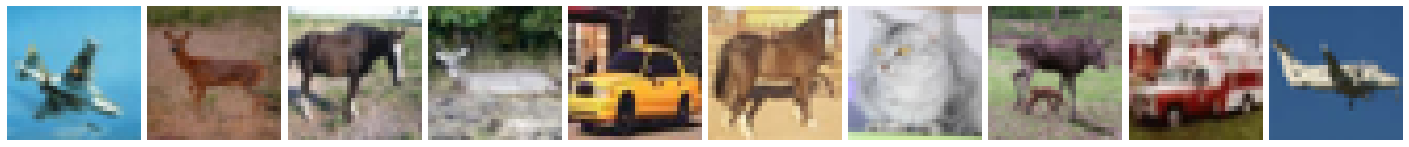

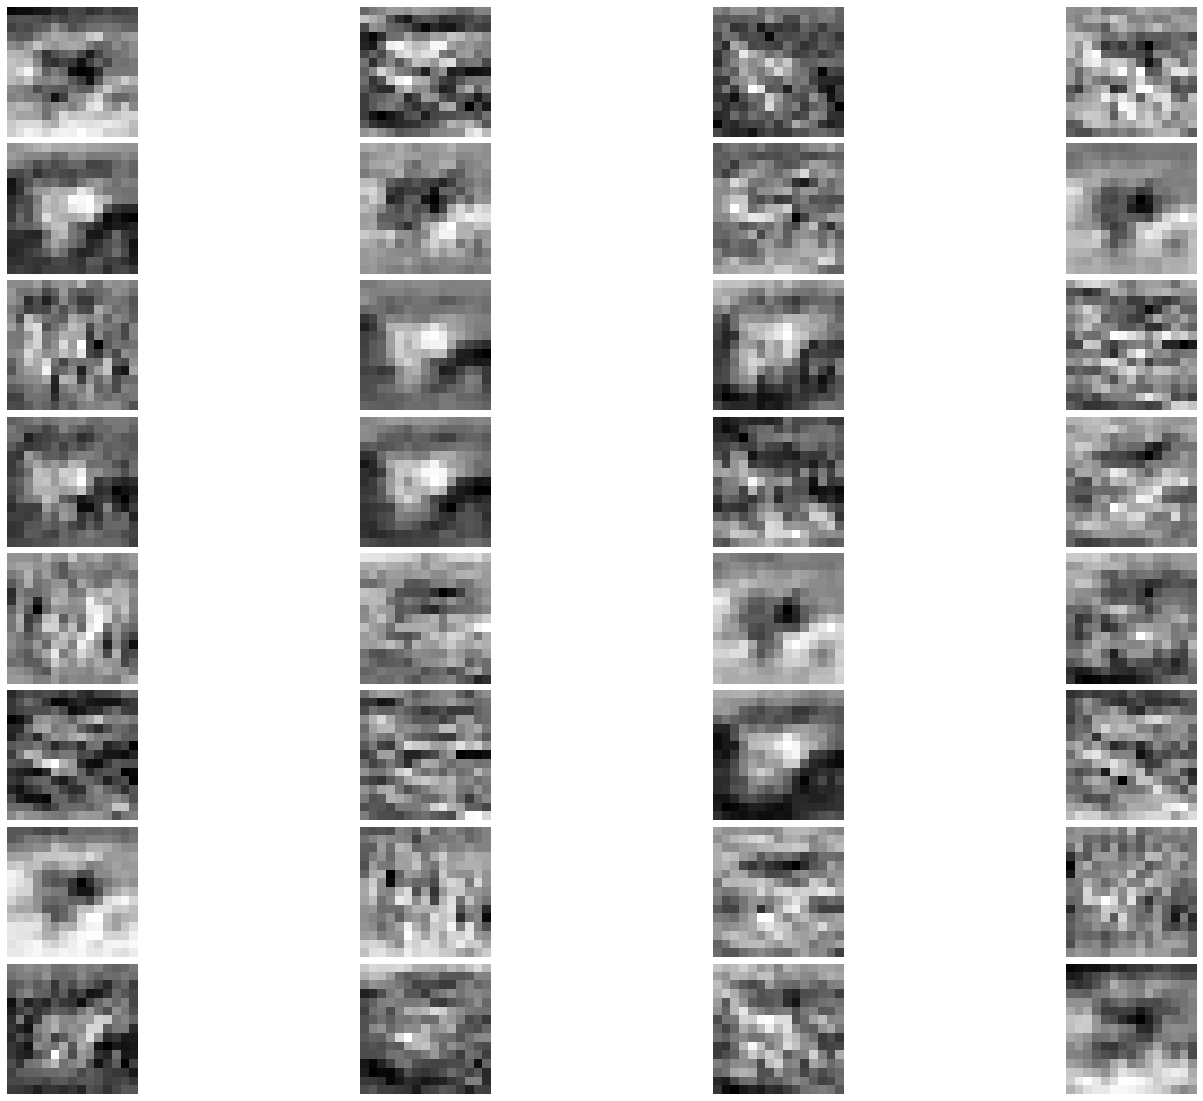

In [6]:
#---------normal reconstruction---------
# For FCNN this will display the full sample(s) including neglible gradient
# For CNN it will show some convoluted activations of a single neuron
# select a number of samples to reconstruct
nrsamples = 10
sampleseti = np.random.choice(np.shape(x_test)[0], nrsamples)

#set correct parameter for first dense layer
if (modelname == 'CNN'): layer = 2
else: layer = 0

#run reconstruction
partial_reconstructions = sample_reconstruct(sampleseti = sampleseti , model = model, layer = layer)

#parameters for visual display
if (dataset == 'MNIST' and modelname=='FCNN'): 
  Partial_form = (28,28)

elif (dataset == 'Cifar10' and modelname=='FCNN'): 
  Partial_form = (32,32,3)
  #Rescale partial reconstructions around zero to avoid clipping while using imshow on multi channel images
  for i in range(0,24):
    pr = np.add(partial_reconstructions[i],np.abs(np.min(partial_reconstructions[i])))
    partial_reconstructions[i] = np.multiply(pr,1/np.max(pr))

elif (dataset == 'Cifar10' and modelname=='CNN'):
  Partial_form = (15,15)
  #if it is CNN we only show results of a single neuron
  partial_reconstructions = np.moveaxis(np.reshape(partial_reconstructions[0],(15,15,32)), 2, 0)

elif (dataset == 'MNIST' and modelname=='CNN'):
  Partial_form = (13,13)
  #if it is CNN we only show results of a single neuron
  partial_reconstructions = np.moveaxis(np.reshape(partial_reconstructions[0],(13,13,32)), 2, 0)

#----visualize----
#display figures and partial reconstructions
Rec_plotsize = (25,20)
Rec_plotlayout = (8,4)
Rec_images_amount = Rec_plotlayout[0]*Rec_plotlayout[1]

#show original sample set
if (nrsamples>1):
  figure, axs = plt.subplots(1, nrsamples, gridspec_kw={'wspace': 0.05, 'hspace': 0.05 }, figsize=Rec_plotsize)
  for i in range(0,nrsamples):
    axs[i].imshow(np.reshape(x_test[sampleseti[i]],input_shape), cmap = 'gray')
    axs[i].axis('off')
  #plt.savefig("Original.eps", format='eps')
  plt.show()
else:
  singleimg = plt.imshow(np.reshape(x_test[sampleseti[0]],input_shape), cmap = 'gray') #if sampleset has size 1, subplots cause errors
  plt.axis('off')
  #plt.savefig("Original.eps", format='eps')

#show partial reconstructions
figure, axs = plt.subplots(Rec_plotlayout[0], Rec_plotlayout[1], gridspec_kw={'wspace': 0.05, 'hspace': 0.05 }, figsize=Rec_plotsize)
for i in range(0,Rec_images_amount):
  if (Rec_plotlayout[0] == 1 ):
    axs[i].imshow(np.reshape(partial_reconstructions[i],Partial_form), cmap = 'gray')
    axs[i].axis('off')
  else: 
    axs[i%Rec_plotlayout[0]][int(np.floor(i/Rec_plotlayout[0]))].imshow(np.reshape(partial_reconstructions[i],Partial_form), cmap = 'gray')
    axs[i%Rec_plotlayout[0]][int(np.floor(i/Rec_plotlayout[0]))].axis('off')
#plt.savefig("partialset.eps", format='eps')
plt.show()

In [ ]:
#--------Generative network reconstruction-----------
#With the victims model, Create adversaryial input-output pairs from suposedly adversarial auxilary dataset
#We take testset 0-<dataset_range> as aux-dataset and draw from <dataset_range>-10000 to provide reconstruction examples.
#!!this may take a fair amount of time.

#!Note It makse no sense to run this part if the chosen network is a FCNN, therefore it will not work.

dataset_aux = []
dataset_pr  = []
dataset_range = 7000

# we use the reconstruction of a sigular neuron as the input 
for i in range(0,dataset_range):
  if(dataset == 'MNIST'):   temp = np.reshape(sample_reconstruct(sampleseti = [i] , model = model, layer = 2),(128,13,13,32))
  if(dataset == 'Cifar10'): temp = np.reshape(sample_reconstruct(sampleseti = [i] , model = model, layer = 2),(128,15,15,32))

  for j in range(0,128): #make sure the reconstrucion is not a non-recreation (by relu or dropout)
    if (np.sum(temp[j]) != 0):
      dataset_pr.append(np.array(temp[j]))
      dataset_aux.append(x_test[i]) #take from testset to ensure the network has not been trained on the specific sample (simulate adversarial dataset)
      break # we only need one neuron for each sample.
  
#split the data into testset and training set ->85% of dataset is training set
# the printed number indicates the data seperatationindex between train and test set (in other words how many test samples there are)
split = int(np.floor(np.shape(dataset_pr)[0]*0.85))
print(split)
dataset_pr_train = np.asarray(dataset_pr[:split])
dataset_pr_test  = np.asarray(dataset_pr[split:])
dataset_aux_train = np.asarray(dataset_aux[:split])
dataset_aux_test  = np.asarray(dataset_aux[split:])

In [ ]:
#declare generative model for MNIST
MNISTGenerativemodel = keras.models.Sequential()
MNISTGenerativemodel.add(keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest',input_shape=(13,13,32)))
MNISTGenerativemodel.add(keras.layers.Conv2D(20, kernel_size=(5,5), activation='relu'))
MNISTGenerativemodel.add(keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')) 
MNISTGenerativemodel.add(keras.layers.Conv2D(10, kernel_size=(5,5), strides=(2,2), activation='relu'))
MNISTGenerativemodel.add(keras.layers.Flatten())
MNISTGenerativemodel.add(keras.layers.Dense(784, activation='sigmoid'))
MNISTGenerativemodel.add(keras.layers.Reshape((28,28)))
MNISTGenerativemodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

#declare generative model for Cifar10
CifarGenerativemodel = keras.models.Sequential()
CifarGenerativemodel.add(keras.layers.Conv2DTranspose(128, kernel_size=(5,5), padding='same', activation='relu', input_shape=(15,15,32)))
CifarGenerativemodel.add(keras.layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu'))
CifarGenerativemodel.add(keras.layers.BatchNormalization())
CifarGenerativemodel.add(keras.layers.Conv2DTranspose(64, kernel_size=(5,5), activation='relu'))
CifarGenerativemodel.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='tanh'))
CifarGenerativemodel.add(keras.layers.Conv2D(3, kernel_size=(3,3), padding='same', activation='sigmoid'))
CifarGenerativemodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#CifarGenerativemodel.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])


if(dataset == 'MNIST'):   Generativemodel = MNISTGenerativemodel
if(dataset == 'Cifar10'): Generativemodel = CifarGenerativemodel

Generativemodel.summary() 
Generativemodel.fit(dataset_pr_train, dataset_aux_train,validation_data=(dataset_pr_test, dataset_aux_test), epochs=40, batch_size=128, verbose=1)
score = Generativemodel.evaluate(dataset_pr_test, dataset_aux_test, batch_size=128)
print(score)

In [ ]:
#-------demo batch sample------
#take samples from 7001+ (<dataset_range>+)
#you can do single sample or batch of samples.
#recsampleset = [7011] #single sample
recsampleset = [7001,7002,7003,7004,7005,7006,7007,7008,7009,7010] #batch
rec_nrsamples = np.shape(recsampleset)[0]

if(dataset == 'MNIST'):   demo_pr_full = np.reshape(sample_reconstruct(sampleseti = recsampleset , model = model, layer = 2),(128,13,13,32)) #!note change layer to suit your network
if(dataset == 'Cifar10'): demo_pr_full = np.reshape(sample_reconstruct(sampleseti = recsampleset , model = model, layer = 2),(128,15,15,32))

demo_pr = []
demo_rec =[]

#get usable partial reconstructions
for i in range(0,128):
  if (np.sum(demo_pr_full[i][:,:,0]) != 0): 
    demo_pr.append(np.array(demo_pr_full[i]))

#get reconstructions from the partial reconstructions
for i in range(0,np.shape(demo_pr)[0]):
  demo_rec.append(Generativemodel.predict(demo_pr[i][np.newaxis,:])[0])

original


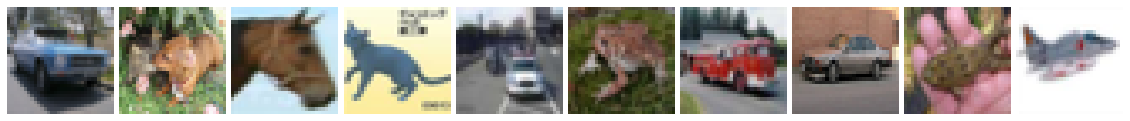

reconstructions


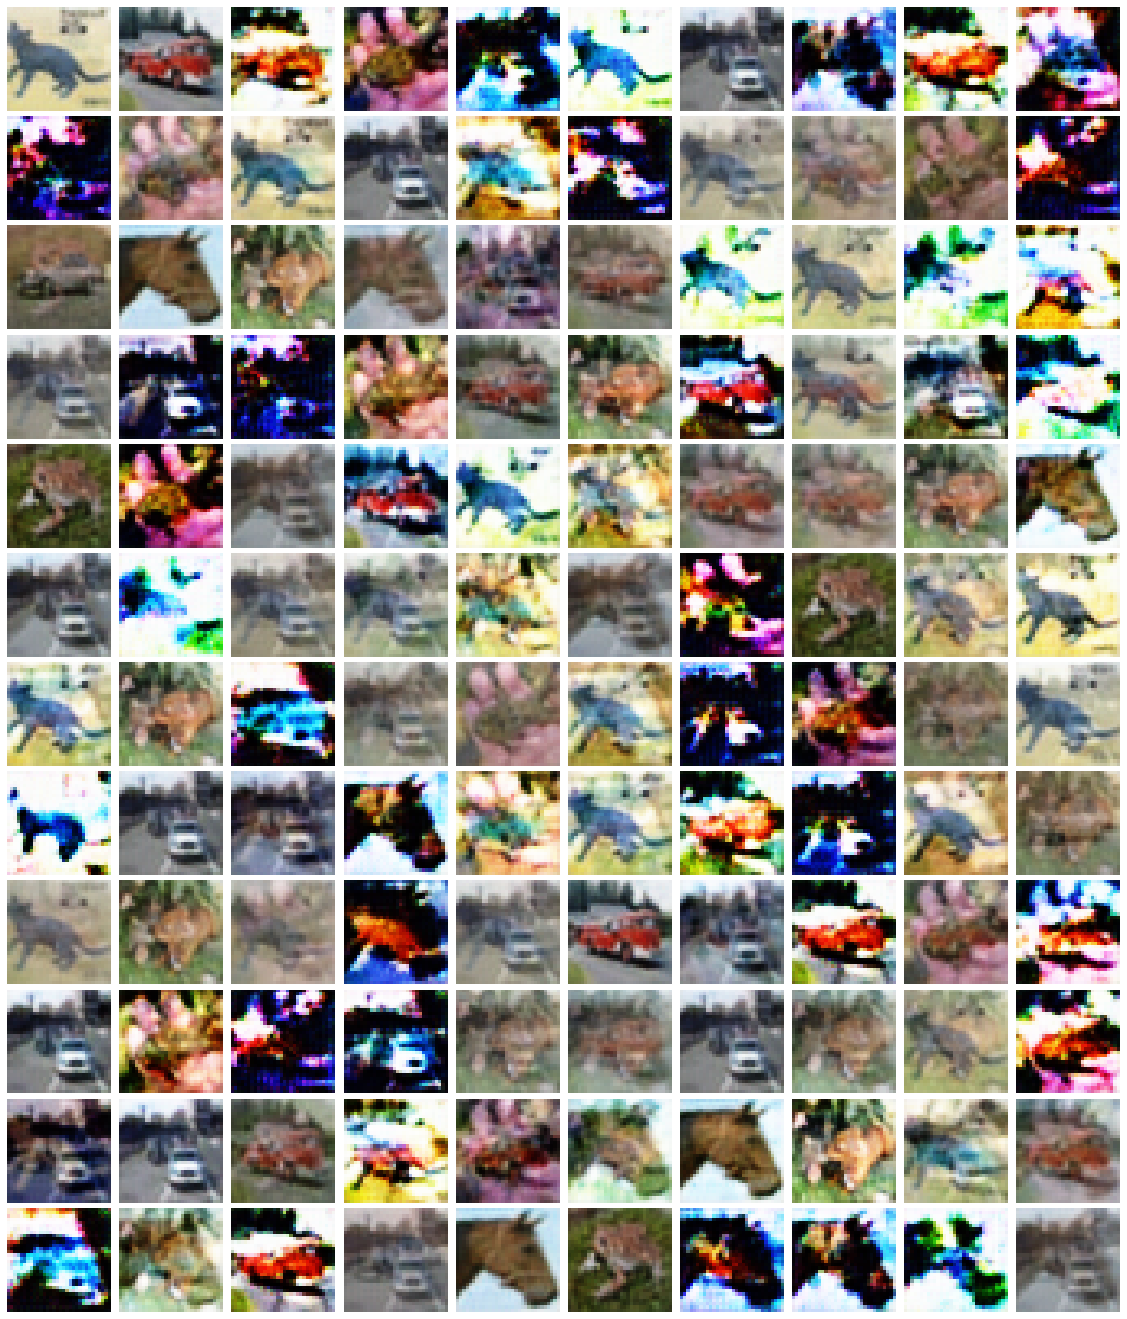

In [ ]:
#show original sample set
print("original")
figure, axs = plt.subplots(1, rec_nrsamples, gridspec_kw={'wspace': 0.05, 'hspace': 0.05 }, squeeze=False,figsize=(20,10))
for i in range(0,rec_nrsamples):
  if(dataset == 'MNIST'):   axs[0,i].imshow(np.reshape(x_test[recsampleset[i]],(28,28)), cmap = 'gray')
  if(dataset == 'Cifar10'): axs[0,i].imshow(np.reshape(x_test[recsampleset[i]],(32,32,3)), cmap = 'gray')
  axs[0,i].axis('off')
#plt.savefig("images/Original.eps", format='eps')
plt.show()

print("reconstructions")
perrow =10 #show reconstructions (10 per row)
rows = int(np.floor(np.shape(demo_rec)[0]/perrow))

figure, axs = plt.subplots(rows, perrow, gridspec_kw={'wspace': 0.05, 'hspace': 0.05 }, squeeze=False, figsize=(20,2*rows))
for i in range(0,(rows*perrow)):
  axs[int(np.floor(i/perrow)),i%perrow].imshow(demo_rec[i], cmap = 'gray')
  axs[int(np.floor(i/perrow)),i%perrow].axis('off')
#plt.savefig("images/partialset.eps", format='eps')
plt.show()